In [1]:
cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder
from src.data import get_sim_ness_data as get_data
from amber.architect import pmbga
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import yaml
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-es75mtay because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


detected tf2 - using compatibility mode


In [3]:
model_params = yaml.load(open("/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_params.yaml"), Loader=yaml.Loader)
model_params = modelParams_to_modelSpace(model_params)
kinn = KineticModel(model_params)
(x_train, y_train), (x_test, y_test) = get_data()

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn/src/data.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_fit'] = np.clip(df['rate_fit'], 1e-8, 10)


In [4]:
mb = KineticEigenModelBuilder(
        kinn=kinn,
        output_op= lambda: tf.keras.layers.Lambda(
            lambda x: tf.math.log(tf.math.maximum(tf.reshape(- x[:,1], (-1,1)), 10**-10)), name="output_slice"),
        n_channels=9,
        n_feats=50,
        replace_conv_by_fc=False)

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(7000/128), # decrease every 10 epochs
    decay_rate=0.9,
    staircase=True)
mb.build(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.))
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)


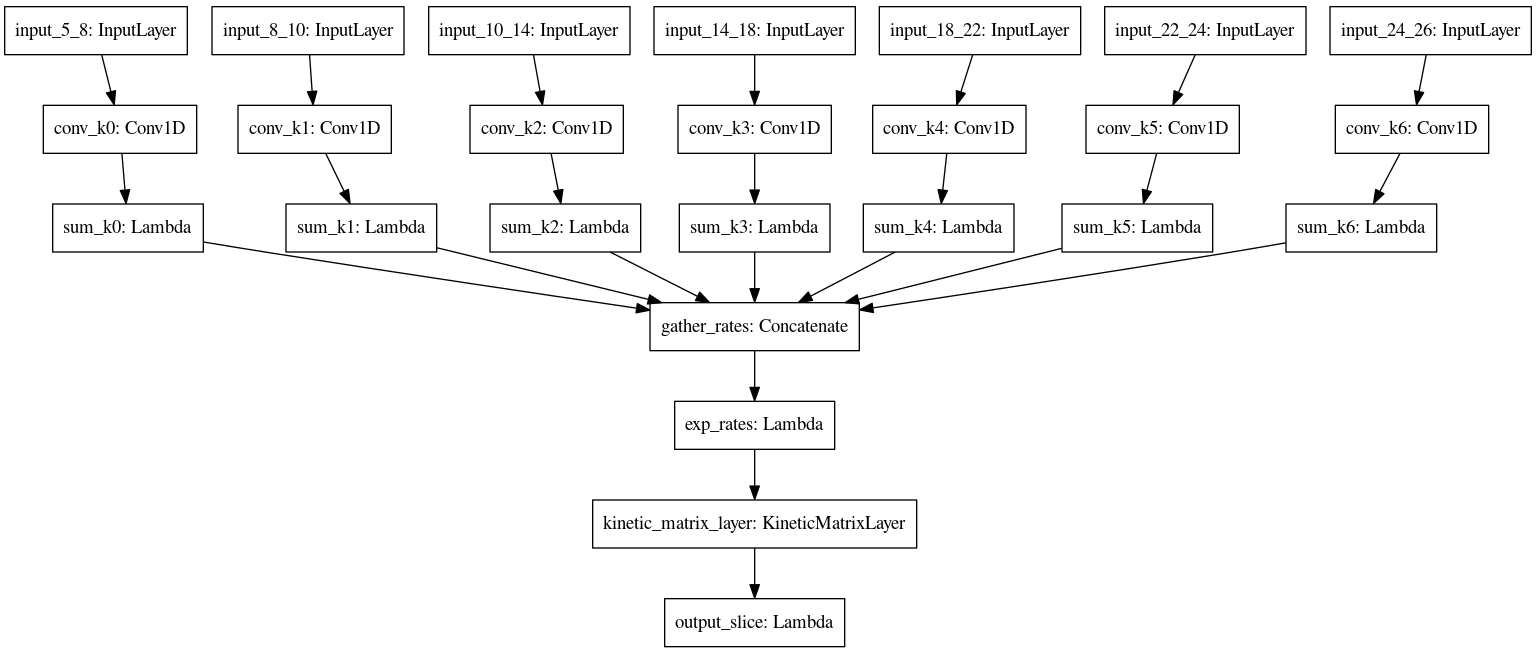

In [5]:
model = mb.model
tf.keras.utils.plot_model(model)

In [6]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=5,
    verbose=0)

hist = model.fit(x_train_b, y_train,
          batch_size=128,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=150, verbose=1)

Train on 3543 samples, validate on 886 samples
Epoch 1/150
3543/3543 [==============================] - ETA: 0s - loss: 3.7779

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3543/3543 [==============================] - 1s 268us/sample - loss: 3.7779 - val_loss: 1.2920
Epoch 2/150
3543/3543 [==============================] - 0s 113us/sample - loss: 0.9653 - val_loss: 0.8473
Epoch 3/150
3543/3543 [==============================] - 0s 112us/sample - loss: 0.7724 - val_loss: 0.7103
Epoch 4/150
3543/3543 [==============================] - 0s 116us/sample - loss: 0.6549 - val_loss: 0.6122
Epoch 5/150
3543/3543 [==============================] - 0s 112us/sample - loss: 0.5714 - val_loss: 0.5286
Epoch 6/150
3543/3543 [==============================] - 0s 121us/sample - loss: 0.4965 - val_loss: 0.4541
Epoch 7/150
3543/3543 [==============================] - 0s 113us/sample - loss: 0.4345 - val_loss: 0.3874
Epoch 8/150
3543/3543 [==============================] - 0s 113us/sample - loss: 0.3729 - val_loss: 0.3336
Epoch 9/150
3543/3543 [==============================] - 0s 116us/sample - loss: 0.3197 - val_loss: 0.2687
Epoch 10/150
3543/3543 [=========================

In [7]:
model.load_weights("bestmodel.h5")
y_hat = model.predict(x_test_b).flatten()
test_reward = ss.pearsonr(np.exp(y_hat), np.exp(y_test))[0]
print(test_reward)

0.97445157088851


Text(0.5, 1.0, 'Pred Eigval vs Fit\npcc=0.974')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


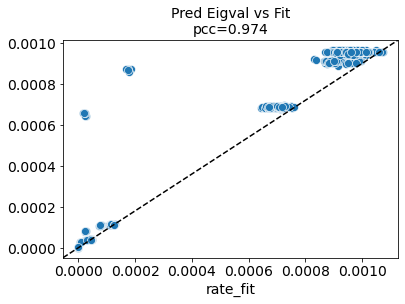

In [8]:
%matplotlib inline
ax = sns.scatterplot(x=np.exp(y_test), y=np.exp(y_hat))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Pred Eigval vs Fit\npcc=%.3f' % test_reward)

Text(0.5, 1.0, 'Obs Eigval vs Fit\npcc=0.996')

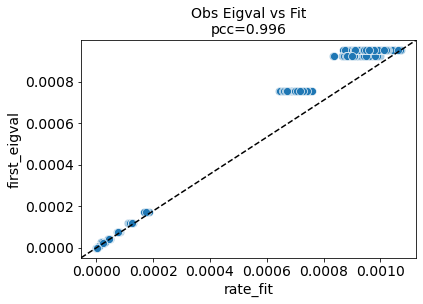

In [9]:
df = pd.read_table('/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_full_data.tsv')
y_eig = - df.loc[y_test.index]['first_eigval']
ax = sns.scatterplot(x=np.exp(y_test), y=y_eig)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Obs Eigval vs Fit\npcc=%.3f' % ss.pearsonr(y_eig, np.exp(y_test))[0])

In [10]:
sub_model = tf.keras.Model(inputs=mb.model.inputs, outputs=mb.model.layers[-2].output)
print(sub_model.predict(x_test_b))

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[[-1.3327984e-08 -9.5746672e-04]
 [-6.6639925e-09 -9.5315796e-04]
 [-1.3327984e-08 -9.5746672e-04]
 ...
 [ 0.0000000e+00 -6.8777805e-04]
 [-1.3327984e-08 -9.5746672e-04]
 [ 1.3326537e-08 -4.9606342e-06]]


In [11]:
df.loc[y_test.index]['first_eigval']

3170   -9.519810e-04
2603   -9.519809e-04
975    -9.519810e-04
2203   -4.312197e-05
508    -9.519810e-04
            ...     
2199   -9.519809e-04
599    -9.256779e-04
329    -7.571739e-04
1273   -9.519810e-04
4098   -3.323684e-07
Name: first_eigval, Length: 886, dtype: float64